In [1]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
from IPython import display

from HH import *

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 15
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["lines.linewidth"] = 1

loadHHLibrary()
findAndConnect()
print("Initialization complete.")

HH library version is 3.0 Jaclav's wraper 1.0

Searching for HydraHarp devices...
Dev_idx     Status
  0        S/N 1999999
  1        no device
  2        no device
  3        no device
  4        no device
  5        no device
  6        no device
  7        no device
Using device #0

Initializing the device...
Initialization complete.


In [2]:
now = datetime.datetime.now()
filename = "data/histomode_" + str(now) + ".csv"
outputfile = open(filename, "w+")
logfile = open(filename.replace("csv", "log"), "w+")

log = getInfo()
logfile.write(log + "\n")
print(log)

Found Model HydraHarp 400 Part no 930020 Version 2.0
Device has 4 input channels.


In [ ]:
log = setEverything(
    binning=5,  # you can change this
    offset=0,
    syncDivider=1,  # you can change this
    syncCFDZeroCross=10,  # you can change this (in mV)
    syncCFDLevel=610,  # you can change this (in mV)
    syncChannelOffset=-5000,  # you can change this (in ps, like a cable delay)
    inputCFDZeroCross=10,  # you can change this (in mV)
    inputCFDLevel=610,  # you can change this (in mV)
    inputChannelOffset=0,  # you can change this (in ps, like a cable delay)
)
print(log, end="")
logfile.write(log)

resolution = getResolution()
log = "Resolution        : " + str(resolution) + "\n"
print(log, end="")
logfile.write(log)

# FIXME:
# Delay 1,2=332.5 ps
# Delay 3,4=341.0 ps
# TO calculate delay: measure dT1, swap cables, measure dT2
# dT1 = d1,2 + pathDelay
# dT2 = d1,2 - pathDelay
log = "Offset ch1        : 330"
print(log)
logfile.write(log + "\n")
tryfunc(
    hhlib.HH_SetInputChannelOffset(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(330)),
    "SetInputChannelOffset",
)

log = "Offset ch4        : 359"
print(log)
logfile.write(log + "\n")
tryfunc(
    hhlib.HH_SetInputChannelOffset(ct.c_int(dev[0]), ct.c_int(3), ct.c_int(359)),
    "SetInputChannelOffset",
)


Calibrating...
Histogram length  : 65536
Binning           : 5
Offset            : 0
SyncDivider       : 1
SyncCFDZeroCross  : 10
SyncCFDLevel      : 610
InputCFDZeroCross : 10
InputCFDLevel     : 610
Resolution        : 32
Offset ch1        : 330


'log = "Offset ch4        : 359"\nprint(log)\nlogfile.write(log + "\n")\ntryfunc(\n    hhlib.HH_SetInputChannelOffset(ct.c_int(dev[0]), ct.c_int(3), ct.c_int(359)),\n    "SetInputChannelOffset",\n)'

In [8]:
log = getRates()
print("\n" + log)
logfile.write(log + "\n")

log = getWarnings()
print("\n" + log)
logfile.write(log + "\n")
logfile.flush()

tryfunc(
    hhlib.HH_SetStopOverflow(ct.c_int(dev[0]), ct.c_int(0), ct.c_int(10000)),
    "SetStopOverflow",
)  # for example only


SyncRate=206.36 kHz
ChRate[1]=0/s
ChRate[2]=0/s
ChRate[3]=0/s
ChRate[4]=218120/s


WARNING_INPT_RATE_RATIO: 
The pulse rate ratio R(ch)/R(sync) is over 5% 
for at least one input channel. 
This may cause pile-up and deadtime artefacts.  


WARNING_TIME_SPAN_TOO_SMALL: 
The sync period is longer than the measurable time 
span at the current resolution. Events falling outside 
this span will not be recorded.  





In [ ]:
tacq = 10000  # Measurement time in millisec, you can change this
log, histLen, numChannels, counts = measureAllInputs(tacq)
print(log)
logfile.write(log + "\n")
logfile.flush()

for j in range(0, histLen):
    for i in range(0, numChannels):
        outputfile.write("%5d " % counts[i][j])
    outputfile.write("\n")
outputfile.flush()

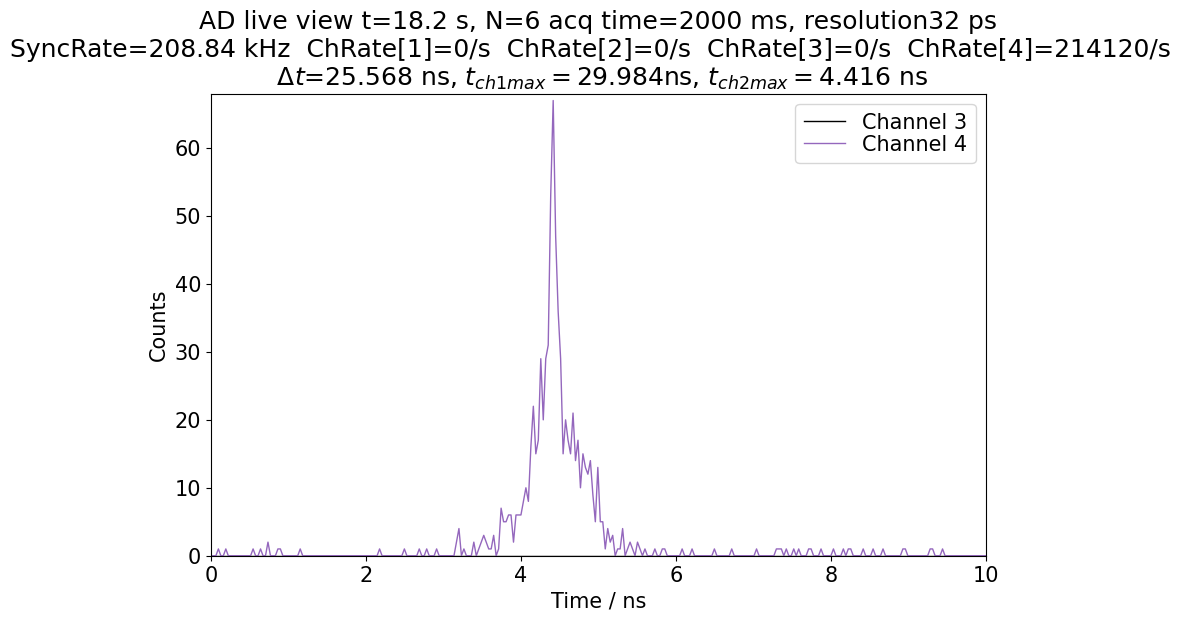

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7695ea37be80>>
Traceback (most recent call last):
  File "/home/jacek/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
"""
| (_)_   _____  __   _(_) _____      __
| | \ \ / / _ \ \ \ / / |/ _ \ \ /\ / /
| | |\ V /  __/  \ V /| |  __/\ V  V /
|_|_| \_/ \___|   \_/ |_|\___| \_/\_/
"""

t0 = time.time()


def findMaxPosition(tab, endSeatching=np.inf):
    maxi = -1
    maxPos = None
    for i, t in enumerate(tab):
        if i > endSeatching:
            break
        if t >= maxi:
            maxi = t
            maxPos = i
    return maxPos


tacq = 2000


def draw(ax, it, hdisplay):
    T = np.linspace(0, 1, 100)
    if not ax.lines:
        return

    log, histLen, numChannels, data = measureAllInputs(tacq)

    line = ax.lines[0]
    ch3 = [data[2][i] for i in range(histLen)]
    T = np.linspace(0, len(ch3), len(ch3)) / 1000 * resolution
    line.set_xdata(T)
    line.set_ydata(ch3)
    line.set_label("Channel 3")

    line = ax.lines[1]
    ch4 = [data[3][i] for i in range(histLen)]
    line.set_xdata(T)
    line.set_ydata(ch4)
    line.set_label("Channel 4")

    ax.set_ylim(0, max(max(ch3), max(ch4)) + 1)

    stopSearch = 30e3 / resolution
    log = getRates()
    ax.set_title(
        "AD live view t="
        + str(round(time.time() - t0, 1))
        + " s, N="
        + str(it)
        + " acq time="
        + str(tacq)
        + " ms, resolution"
        + str(resolution)
        + " ps\n"
        + log.replace("\n", "  ")
        + "\n $\Delta t$="
        + str(
            round(
                (findMaxPosition(ch3, stopSearch) - findMaxPosition(ch4, stopSearch))
                / 1e3
                * resolution,
                3,
            )
        )
        + " ns, $t_{ch1max}=$"
        + str(round(findMaxPosition(ch3, stopSearch) / 1e3 * resolution, 3))
        + "ns, $t_{ch2max}=$"
        + str(round(findMaxPosition(ch4, stopSearch) / 1e3 * resolution, 3))
        + " ns"
    )
    ax.legend()
    hdisplay.update(fig)


ax = None
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0, 70)
ax.set_xlim(0, 10)
ax.set_ylim(0, 3)
ax.set_xlabel("Time / ns")
ax.set_ylabel("Counts")

hdisplay = display.display("", display_id=True)
T = np.linspace(0, 100)
ax.plot(T, T * 0, color="black")
ax.plot(T, T * 0, color="#9467bd")

for i in range(100):
    draw(ax, i, hdisplay=hdisplay)

In [9]:
fig.savefig(
    filename.replace(".csv", "_live.png"), dpi=300, bbox_inches="tight", pad_inches=0.1
)

plt.close(fig)

In [ ]:
# writing to file and quitting
closeDevices()
outputfile.close()
logfile.close()

In [ ]:
print(filename)
data = np.loadtxt(filename)
ch1 = data[:, 0]
ch2 = data[:, 1]
ch3 = data[:, 2]
ch4 = data[:, 3]

T = np.linspace(0, len(ch1), len(ch1)) / 1000 * resolution


if True:
    plt.plot(T, ch1, label="Channel 1", color="#1f77b4")
    plt.plot(T, ch2, label="Channel 2", color="#ff7f0e")
    plt.plot(T, ch3, label="Channel 3", color="black")
    plt.plot(T, ch4, label="Channel 4", color="#9467bd")
else:
    bins_time = np.linspace(min(T), max(T), 200)  # 5 przedziałów czasowych
    binnin_res = (bins_time[1] - bins_time[0]) * 1e3  # ps
    print("Bins", binnin_res, " ps")
    plt.hist(T, bins=bins_time, weights=ch3, label="Channel 3", color="black")

plt.legend()
plt.xlim(0, 20)
plt.xlabel("Time / ns")
plt.ylabel("Counts")
plt.yscale("log")

# plt.title("swapped")
plt.savefig(filename.replace(".csv", ".png"))

data/histomode_2025-09-12 18:44:48.749315.csv


/tmp/ipykernel_36456/1036608741.py:2: UserWarning: loadtxt: input contained no data: "data/histomode_2025-09-12 18:44:48.749315.csv"
  data = np.loadtxt(filename)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
dataA = np.loadtxt("data/histomode_2025-09-10 16:37:59.611794.csv")
# dataB = np.loadtxt("data/histomode_2025-09-10 15:50:40.505662.csv", skipchs=9)

ch1A = dataA[:, 2]
ch2A = dataA[:, 3]

# ch1B = dataB[:, 2]
# ch2B = dataB[:, 3]


def f(data):
    maxi = 0
    ptrMaxi = 0
    for i in range(0, 20000):
        if data[i] > maxi:
            maxi = data[i]
            ptrMaxi = i
    return ptrMaxi


print(f(ch1A), f(ch2A), -f(ch2A) + f(ch1A))
# print(f(ch1B), f(ch2B), -f(ch2B) + f(ch1B))

# hpd = max('''-f(ch2B) + f(ch1B),''' -f(ch2A) + f(ch1A))
# hmd = min('''-f(ch2B) + f(ch1B),''' -f(ch2A) + f(ch1A))

# print("Hydra's delay:", (hpd + hmd) / 2)
# print("Path delay:", (hpd - hmd) / 2)